<a href="https://colab.research.google.com/github/diptisahu/Emoji-Prediction/blob/main/DNN_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

import re
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Github/

/content/drive/MyDrive/Github


In [ ]:
!pip install sentence-transformers

In [ ]:
def clean(text):
    """ Function to clean the text """
    text = text.lower()
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    
    # Remove numbers from string
    texter = re.sub(pattern=r"[+-]?\d+(?:\.\d+)?", repl="", string=texter, count=0, flags=0)
    texter = texter.replace("  ", " ")
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    texter = re.sub(r'[^\w\s]', '', texter)
    if texter == "":
        texter = ""
    return texter

In [ ]:
# inputs_file = "./tweets_training.txt"
# labels_file = "./tweets_training_labels.txt"

inputs_file = "./tweet.text"
labels_file = "./tweet_labels.txt"

X = []
with open(inputs_file, encoding='utf8') as f:
    for line in f:
        X.append(line)
f.close()
# print(len(X))

y = []
with open(labels_file, encoding='utf8') as f:
    for line in f:
        y.append(int(line))
f.close()



In [ ]:
# X = X[:1000]
# y = y[:1000]

In [ ]:
cleaned_x = []
for line in X:
  cleaned_x.append(clean(line))

In [ ]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens', device='cuda')

In [ ]:
sentence_embeddings = sbert_model.encode(cleaned_x, show_progress_bar=True)
raw_X = sentence_embeddings

Batches:   0%|          | 0/11028 [00:00<?, ?it/s]

In [ ]:
# 0
# 0.01
# 0.02
# 0.05
# 0.1
# 0.2
# 0.3
# 0.5
print(raw_X.shape)
weighing_scale = 0.1
new_item = []
for item in raw_X:
  noise = np.random.randn(768) * weighing_scale
  new_item.append(noise + item)

X = np.array(new_item)
print(X.shape)

(352867, 768)
(352867, 768)


In [ ]:
# Hyperparameters
# num_epochs = 10
# batch_size = 64
# learning_rate = 0.0001
# dropout = 0.25

num_epochs = 10
batch_size = 256
learning_rate = 0.0001
dropout = 0.25

In [ ]:
# X = transform(X, "DNN")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

X_tr = torch.tensor(X_train, dtype=torch.float)
y_tr = torch.tensor(y_train)
train = TensorDataset(X_tr, y_tr)
trainloader = DataLoader(train, batch_size=batch_size)

X_te = torch.tensor(X_test, dtype=torch.float)
y_te = torch.tensor(y_test)
test = TensorDataset(X_te, y_te)
testloader = DataLoader(test)

In [ ]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(768, 1000)
        self.hidden1 = nn.Linear(1000, 500)
        self.hidden2 = nn.Linear(500, 350)

        self.fc2 = nn.Linear(350, 20)
        self.dropout = nn.Dropout(0.25)
        
        self.batchnorm1 = nn.BatchNorm1d(1000)
        self.batchnorm2 = nn.BatchNorm1d(500)
        self.batchnorm3 = nn.BatchNorm1d(350)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = F.relu(self.hidden1(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = F.relu(self.hidden2(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

net = Net().to('cuda')

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

# create your optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [ ]:
# Training
LS = []
LSsmall = []
net.train()
for epoch in range(num_epochs):
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        LS.append(loss.data)

        if (i+1) % 500 == 0:
            LSsmall.append(loss.data)
            print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                   %(epoch+1, num_epochs, i+1, len(trainloader), loss.data))

Epoch [1/10], Step [500/1172], Loss: 2.5231
Epoch [1/10], Step [1000/1172], Loss: 2.4626
Epoch [2/10], Step [500/1172], Loss: 2.3931
Epoch [2/10], Step [1000/1172], Loss: 2.2955
Epoch [3/10], Step [500/1172], Loss: 2.3274
Epoch [3/10], Step [1000/1172], Loss: 2.3053
Epoch [4/10], Step [500/1172], Loss: 2.3168
Epoch [4/10], Step [1000/1172], Loss: 2.2480
Epoch [5/10], Step [500/1172], Loss: 2.2874
Epoch [5/10], Step [1000/1172], Loss: 2.2532
Epoch [6/10], Step [500/1172], Loss: 2.2579
Epoch [6/10], Step [1000/1172], Loss: 2.2177
Epoch [7/10], Step [500/1172], Loss: 2.2164
Epoch [7/10], Step [1000/1172], Loss: 2.2250
Epoch [8/10], Step [500/1172], Loss: 2.2233
Epoch [8/10], Step [1000/1172], Loss: 2.1680
Epoch [9/10], Step [500/1172], Loss: 2.1925
Epoch [9/10], Step [1000/1172], Loss: 2.1799
Epoch [10/10], Step [500/1172], Loss: 2.2058
Epoch [10/10], Step [1000/1172], Loss: 2.1412


In [ ]:
# Testing
total, correct = 0, 0

net.eval()
X_te = X_te.to('cuda')
y_te = y_te.to('cuda')

outputs = net(X_te)

_, predicted = torch.max(outputs, 1)

total += y_te.size(0)
correct += (predicted == y_te).sum()

print(f'Accuracy of the model is: {100*correct/total:.2f}%')

Accuracy of the model is: 32.52%


In [ ]:
print(LSsmall)

LSsmallnew = [x.cpu() for x in LSsmall]

[tensor(2.5058, device='cuda:0'), tensor(2.4190, device='cuda:0'), tensor(2.3720, device='cuda:0'), tensor(2.3192, device='cuda:0'), tensor(2.2812, device='cuda:0'), tensor(2.2885, device='cuda:0'), tensor(2.2670, device='cuda:0'), tensor(2.2436, device='cuda:0'), tensor(2.2770, device='cuda:0'), tensor(2.2372, device='cuda:0'), tensor(2.2632, device='cuda:0'), tensor(2.2127, device='cuda:0'), tensor(2.2367, device='cuda:0'), tensor(2.2002, device='cuda:0'), tensor(2.2220, device='cuda:0'), tensor(2.1956, device='cuda:0'), tensor(2.2017, device='cuda:0'), tensor(2.1781, device='cuda:0'), tensor(2.1742, device='cuda:0'), tensor(2.1638, device='cuda:0')]


In [ ]:

LSnew = [x.cpu() for x in LS]

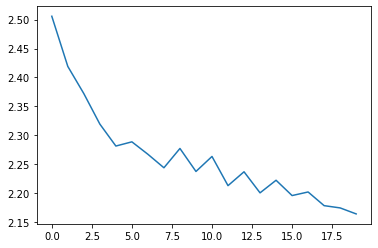

In [ ]:
from matplotlib import pyplot as plt

plt.plot(LSsmallnew)

Text(0, 0.5, 'Loss')

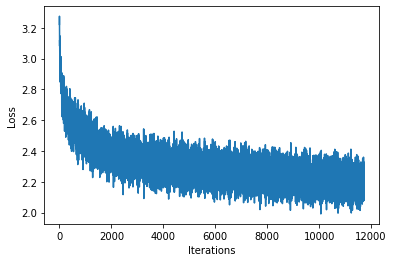

In [ ]:
from matplotlib import pyplot as plt

plt.plot(LSnew)
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [ ]:
X.shape

(352867, 768)

In [ ]:
X_lstm = X.reshape(X.shape[0], 1, X.shape[1])
X_lstm.shape

(352867, 1, 768)

In [ ]:
# Hyperparameters
num_epochs = 10
batch_size = 256
learning_rate = 0.0005
dropout = 0.5

In [ ]:
class LSTM(nn.Module): 
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, dropout):
        super(LSTM, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, dropout=dropout, batch_first=True).to('cuda') #lstm
        self.fc1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc2 = nn.Linear(128, num_classes) #fully connected last layer

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to('cuda') #hidden state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to('cuda') 
        
        # Propagate input through LSTM
        x, _ = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        
        # Flatten lstm output
        x = x[:, -1, :]
        
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

lstm = LSTM(20, 768, 128, 2, 768, dropout).to('cuda')

In [ ]:
## LSTM
# X = transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y, test_size=0.15, random_state=42)


X_tr = torch.tensor(X_train, dtype=torch.float)
y_tr = torch.tensor(y_train)
train = TensorDataset(X_tr, y_tr)
X_tr = X_tr.to(device='cuda')
y_tr = y_tr.to(device='cuda')
trainloader = DataLoader(train, batch_size=batch_size)

X_te = torch.tensor(X_test, dtype=torch.float)
y_te = torch.tensor(y_test)
X_te = X_te.to(device='cuda')
y_te = y_te.to(device='cuda')
test = TensorDataset(X_te, y_te)
testloader = DataLoader(test)

print(len(y_tr))
print(X_tr.size())

299936
torch.Size([299936, 1, 768])


In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

# create your optimizer
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate)

In [ ]:
# Training
# lstm = lstm.to(device="cuda")
# trainloader.to(device="cuda")
for epoch in range(num_epochs):
    running_loss = 0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')

        outputs = lstm(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        optimizer.zero_grad()

        running_loss += loss.item()
        
        if (i+1) % 250 == 0:
            print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                   %(epoch+1, num_epochs, i+1, len(X_tr)//batch_size, loss.data))

Epoch [1/10], Step [250/1171], Loss: 2.8282
Epoch [1/10], Step [500/1171], Loss: 2.8541
Epoch [1/10], Step [750/1171], Loss: 2.8476
Epoch [1/10], Step [1000/1171], Loss: 2.7775
Epoch [2/10], Step [250/1171], Loss: 2.7926
Epoch [2/10], Step [500/1171], Loss: 2.8464
Epoch [2/10], Step [750/1171], Loss: 2.8333
Epoch [2/10], Step [1000/1171], Loss: 2.7729
Epoch [3/10], Step [250/1171], Loss: 2.7657
Epoch [3/10], Step [500/1171], Loss: 2.8247
Epoch [3/10], Step [750/1171], Loss: 2.8083
Epoch [3/10], Step [1000/1171], Loss: 2.7650
Epoch [4/10], Step [250/1171], Loss: 2.7647
Epoch [4/10], Step [500/1171], Loss: 2.8238
Epoch [4/10], Step [750/1171], Loss: 2.8212
Epoch [4/10], Step [1000/1171], Loss: 2.7698
Epoch [5/10], Step [250/1171], Loss: 2.7710
Epoch [5/10], Step [500/1171], Loss: 2.8168
Epoch [5/10], Step [750/1171], Loss: 2.8213
Epoch [5/10], Step [1000/1171], Loss: 2.7652
Epoch [6/10], Step [250/1171], Loss: 2.7573
Epoch [6/10], Step [500/1171], Loss: 2.8173
Epoch [6/10], Step [750/117

In [ ]:
# Testing
total, correct = 0, 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')

        outputs = lstm(inputs)

        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum()

print(f'Accuracy of the model is: {100*correct/total:.2f}%')

Accuracy of the model is: 26.93%
